In [1]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import sounddevice as sd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


sampling rate: samples per second
signal length: total number of samples

In [2]:
sampling_rate, data = wav.read('voice1.wav')
print('sampling rate:', sampling_rate)
print('data type:', data.dtype)
print('data shape:', data.shape)
signal_length, no_channels = data.shape
print('signal length:', signal_length)
channel0 = data[:, 0]
channel1 = data[:, 1]

sampling rate: 44100
data type: int16
data shape: (149058, 2)
signal length: 149058


In [3]:
def save_wav(filename, data, samplerate):
    wav.write(filename, samplerate, data)


def play_audio(data, samplerate):
    sd.play(data, samplerate)
    sd.wait()


def plot_signal(signal, title=None):
    x = np.arange(0, signal.shape[0])
    if signal.ndim == 2:
        y = signal[:, 0]
    elif signal.ndim == 1:
        y = signal
    else:
        print("woa, what is happening")
    plt.plot(x, y, 'b')
    plt.xlabel('samples(time)')
    plt.ylabel('amplitude')
    if title is not None:
        plt.title(title)
    plt.figure()

increasing audio

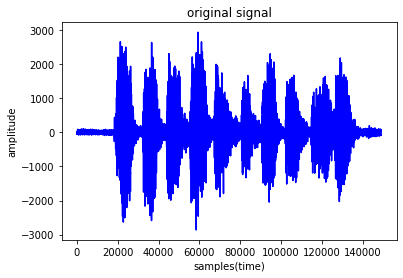

<Figure size 432x288 with 0 Axes>

In [4]:
plot_signal(data, title='original signal')

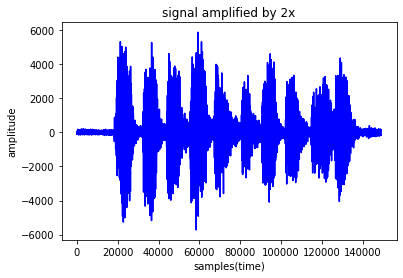

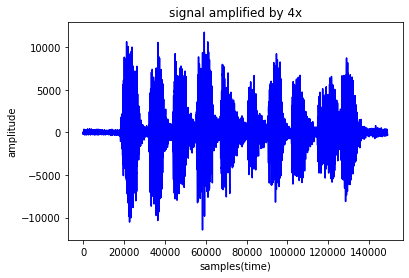

<Figure size 432x288 with 0 Axes>

In [5]:
data_loud_2 = data * 2
data_loud_4 = data * 4
plot_signal(data_loud_2, title='signal amplified by 2x')
plot_signal(data_loud_4, title='signal amplified by 4x')

2)

In [6]:
eventual_gain = np.linspace(-2, 4, num=signal_length)
increasing_volume_data = np.array(data)
increasing_volume_data[:, 0] = increasing_volume_data[:, 0] * eventual_gain
increasing_volume_data[:, 1] = increasing_volume_data[:, 1] * eventual_gain
play_audio(increasing_volume_data, sampling_rate)

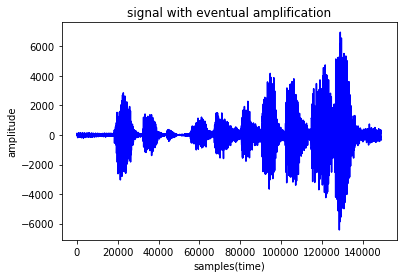

<Figure size 432x288 with 0 Axes>

In [7]:
plot_signal(increasing_volume_data, title='signal with eventual amplification')

3)

![](/media/msgh/baka/study/4022/network_1/projects/p2/project_source/a_law_compression_formula.png)
compression formula for A law &#8593;
![](/media/msgh/baka/study/4022/network_1/projects/p2/project_source/a_law_decompression_formula.png)
decompression formula for A law &#8593;

In [8]:
def a_law_compress(x, A=87.6):
    absx = np.abs(x)
    sgnx = np.sign(x)
    lna = np.log(A)
    lnax = np.log(A * absx)
    sth = np.where(absx < 1 / A,
                   (A * absx) / (1 + lna),
                   (1 + lnax) / (1 + lna))
    return sth * sgnx


def a_law_decompress(y, A=87.6):
    absy = np.abs(y)
    sgny = np.sign(y)
    lna = np.log(A)
    return sgny * np.where(absy < 1 / (1 + lna),
                           (absy * (1 + lna)) / A,
                           np.exp(-1 + (absy * (1 + lna))) / A)

/tmp/ipykernel_113777/478743283.py:5: RuntimeWarning: divide by zero encountered in log
  lnax = np.log(A * absx)


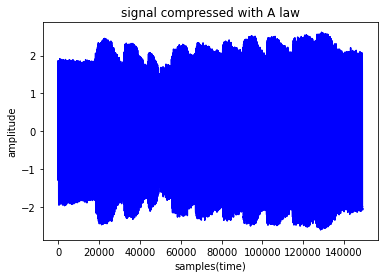

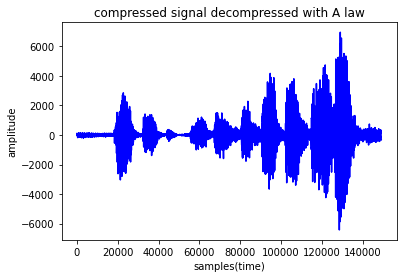

<Figure size 432x288 with 0 Axes>

In [9]:
a_comp = a_law_compress(increasing_volume_data)
a_decomp = a_law_decompress(a_comp)
plot_signal(a_comp, 'signal compressed with A law')
plot_signal(a_decomp, 'compressed signal decompressed with A law')

![](/media/msgh/baka/study/4022/network_1/projects/p2/project_source/m_law_compression_formula.png)
compression formula for M law &#8593;
![](/media/msgh/baka/study/4022/network_1/projects/p2/project_source/m_law_decompression_formula.png)
decompression formula for M law &#8593;

In [10]:
def mu_law_compress(x, mu=255):
    abs_x = np.abs(x)
    sign_x = np.sign(x)
    compressed = sign_x * np.log(1 + mu * abs_x) / np.log(1 + mu)
    return compressed


def mu_law_decompress(y, mu=255):
    abs_y = np.abs(y)
    sign_y = np.sign(y)
    expanded = sign_y * (np.exp(abs_y * np.log(1 + mu)) - 1) / mu
    return expanded

/tmp/ipykernel_113777/2396807273.py:4: RuntimeWarning: divide by zero encountered in log
  compressed = sign_x * np.log(1 + mu * abs_x) / np.log(1 + mu)
/tmp/ipykernel_113777/2396807273.py:4: RuntimeWarning: invalid value encountered in log
  compressed = sign_x * np.log(1 + mu * abs_x) / np.log(1 + mu)


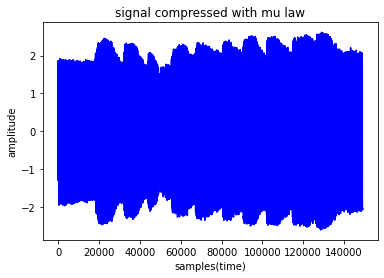

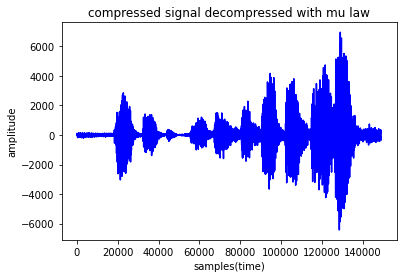

<Figure size 432x288 with 0 Axes>

In [11]:
mu_comp = mu_law_compress(increasing_volume_data)
mu_decomp = mu_law_decompress(a_comp)
plot_signal(a_comp, 'signal compressed with mu law')
plot_signal(a_decomp, 'compressed signal decompressed with mu law')

findings: this type of PCM helps to decrease the amplitude and therefore compress the signal. As a result, the compressed signal can be transmitted and then the reverse process (decompression) happens at the receiving node.

4) delta modulation:
    pros: simple to implement
    cons: not as accurate as other analog to digital conversion methods

In [12]:
def delta_modulation(signal, step_size):
    previous_value = 0
    output = np.zeros(len(signal))
    for i in range(0, len(signal)):
        if signal[i] > previous_value:
            output[i] = 1
            previous_value += step_size
        else:
            output[i] = 0
            previous_value -= step_size
    return output

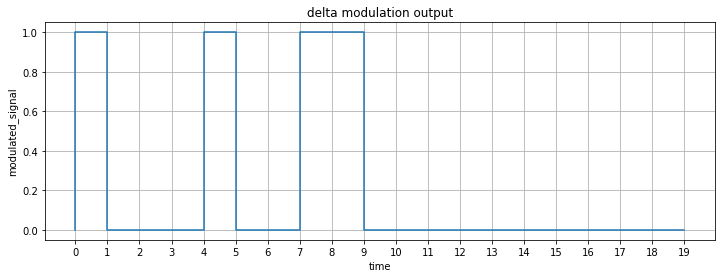

In [13]:
m = delta_modulation(data_loud_2[:, 0], 2)
y = m[:20]
x = np.arange(0, 20, 1)
plt.figure(figsize=(12, 4))
plt.step(x, y)
plt.grid(True)
plt.xlabel('time')
plt.ylabel('modulated_signal')
plt.title('delta modulation output')
plt.xticks(ticks=x)
plt.show()

level 5: quantization

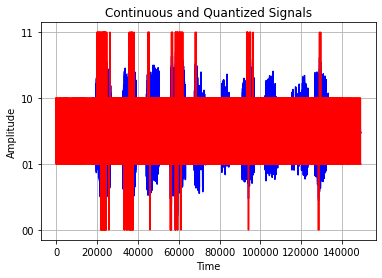

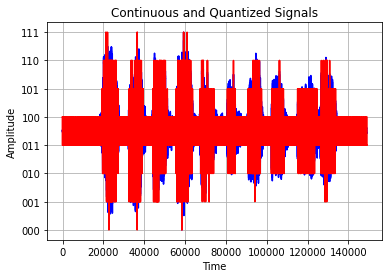

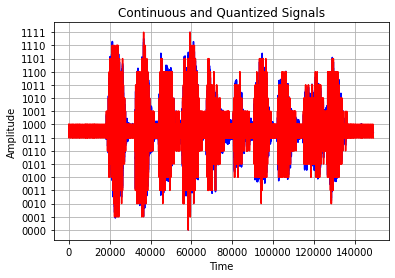

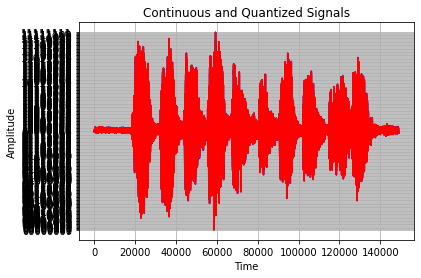

In [14]:
def quantize(data, bit_depth):
    max_val = np.max(data)
    min_val = np.min(data)
    levels = 2 ** bit_depth
    step_size = (max_val - min_val) / (levels - 1)
    quantized_signal = np.round((data - min_val) / step_size) * step_size + min_val
    x = np.arange(0, len(quantized_signal))
    plt.plot(x, data, label='Continuous Signal', color='blue')
    plt.step(x, quantized_signal, where='mid', label='Quantized Signal', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Continuous and Quantized Signals')
    plt.grid(True)

    y_ticks = np.linspace(quantized_signal.min(), quantized_signal.max(), levels)
    y_labels = [format(i,'0'+ str(bit_depth)+ 'b') for i in range(levels)]
    plt.yticks(y_ticks, y_labels)
    plt.show()
    return quantized_signal

quantization = quantize(data, 2)
quantization = quantize(data, 3)
quantization = quantize(data, 4)
quantization = quantize(data, 8)

6) let's speed things up
#todo what is logic behind changing the speed of playback without changing the tone of voice?

In [15]:
play_audio(data, sampling_rate*2)